In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

if __name__=="__main__":
    # df = pd.read_parquet("/prices_AAPL.parquet")
    df = pd.read_csv("/content/drive/MyDrive/551Project/merged_AAPL_60m_191001_191231.csv")
    # df = pd.read_csv("/content/first500_AAPL_merged.csv",index_col=False);
    df.drop(columns=['<VOL>'], inplace=True)
    # df = df.iloc[: , 1:]
    df.sort_values(by='<TIME>', ascending=True, inplace=True)
    df.set_index("<TIME>", inplace=True)

    print("---dataframe head---")
    print(df.head())

    print("--scaling data---")
    df = df.iloc[: , [0,1,2,3,4,6,7]]
    data = sc.fit_transform(df)

    train_ind = int(0.8*len(df))
    # val_ind = train_ind + int(0.2*len(df))

    train = data[:train_ind]
    # val = data[train_ind:val_ind]
    # test = data[val_ind:]
    test = data[train_ind:]


    print("--shapes--")
    print("train, test",train.shape, test.shape)

    n_features = 7
    xtrain,ytrain,xtest,ytest = train[:,:n_features],train[:,3],test[:,:n_features],test[:,3]
    print(xtest.shape, ytest.shape)

    # lookback = 60
    lookback = 5

    
    train_len = len(xtrain) - lookback
    test_len = len(xtest) - lookback
    # val_len = len(xval) - lookback

    x_train = np.zeros((train_len, lookback, n_features))
    y_train = np.zeros((train_len))
    for i in range(train_len):
        ytemp = i+lookback
        x_train[i] = xtrain[i:ytemp]
        y_train[i] = ytrain[ytemp]
    print("x_train", x_train.shape)
    print("y_train", y_train.shape)

    x_test = np.zeros((test_len, lookback, n_features))
    y_test = np.zeros((test_len))
    for i in range(test_len):
        ytemp = i+lookback
        x_test[i] = xtest[i:ytemp]
        y_test[i] = ytest[ytemp]
    print("x_test", x_test.shape)
    print("y_test", y_test.shape)

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80, verbose=1, mode='min')

    # x_val = np.zeros((val_len, lookback, n_features))
    # y_val = np.zeros((val_len))
    # for i in range(val_len):
    #     ytemp = i+lookback
    #     x_val[i] = xval[i:ytemp]
    #     y_val[i] = yval[ytemp]
    # print("x_val", x_val.shape)
    # print("y_val", y_val.shape)


---dataframe head---
                     <OPEN>  <HIGH>  ...  tw_n_neg  tw_ratio_neg
<TIME>                               ...                        
2019-10-01 10:00:00  225.13  228.22  ...         0      0.000000
2019-10-01 11:00:00  228.05  228.08  ...         1      0.045455
2019-10-01 12:00:00  226.18  227.66  ...         1      0.030303
2019-10-01 13:00:00  226.26  226.28  ...        12      0.111111
2019-10-01 14:00:00  225.36  225.52  ...        11      0.135802

[5 rows x 10 columns]
--scaling data---
--shapes--
train, test (350, 7) (88, 7)
(88, 7) (88,)
x_train (345, 5, 7)
y_train (345,)
x_test (83, 5, 7)
y_test (83,)


In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [ ]:
import tensorflow
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model


X_train, X_test = x_train, x_test


def build_model(hp):
    model = Sequential()
    # number of hidden layer
    hidden = hp.Int("n_hidden", min_value=0, max_value=3)
    # first LSTM−Layer
    model.add(LSTM(units=hp.Int("n_units1", min_value=17, max_value=500, step=50),
                   activation=hp.Choice("v_activation", values=["relu", "tanh", "sigmoid"], default="relu"),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True if hidden > 0 else False))
    

    if hidden > 0:
        for layer in range(hidden):
            model.add(Dropout(hp.Float("v_dropout_hidden" + str(layer + 1), min_value=0.05, max_value=0.95, step=0.05)))
            model.add(LSTM(units=hp.Int("n_units_hidden" + str(layer + 1), min_value=17,
                                        max_value=250,
                                        step=50),
                           activation="relu",
                           return_sequences=True if layer != hidden else False))

    model.add(Dropout(hp.Float("v_dropout", min_value=0.05, max_value=0.95, step=0.05)))
    model.add(Dense(units=1))

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


tuner = RandomSearch(build_model,
                     objective="val_loss", 
                     max_trials=50,
                    #  max_trials=1,
                     seed=1,
                     executions_per_trial=3, directory="/content/drive/MyDrive/551Project/tweet_7",
                    #  overwrite=False, 
                     project_name=""
                     )

early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tuner.search(X_train, y_train,
             epochs=100,
             # epochs=1500,
             batch_size=32,
             validation_split=0.2, callbacks=[early_stopping_cb], verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
# save best model for that variable combination
best_model.save("best_model.h5")
# Evaluate the best model with test data
loss = best_model.evaluate(X_test, y_test)


INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/551Project/tweet_7/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/551Project/tweet_7/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
5/5 [==============================] - 1s 7ms/step - loss: 3.1235e-04


In [ ]:
best_model.save("/content/drive/MyDrive/551Project/tweet_lookback5.h5")

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 217)               195300    
                                                                 
 dropout (Dropout)           (None, 217)               0         
                                                                 
 dense (Dense)               (None, 1)                 218       
                                                                 
Total params: 195,518
Trainable params: 195,518
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
9/9 [==============================] - 0s 25ms/step - loss: 3.3500e-04 - val_loss: 3.5923e-04
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 3.6790e-04 - val_loss: 3.5886e-04
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 3.4910e-04 - val_loss: 3.6020e-04
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 4.1346e-04 - val_loss: 3.6754e-04
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 4.1593e-04 - val_loss: 3.7447e-04
Epoch 6/100
9/9 [==============================] - 0s 23ms/step - loss: 4.7045e-04 - val_loss: 3.7376e-04
Epoch 7/100
9/9 [==============================] - 0s 20ms/step - loss: 4.9103e-04 - val_loss: 3.8911e-04
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 5.4762e-04 - val_loss: 3.7061e-04
Epoch 9/100
9/9 [==============================] - 0s 21ms/step - loss: 5.0579e-04 - val_loss: 3.6074e-04
Epoch 10/100
9/9 [============================

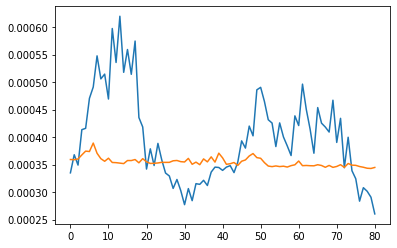

r2_score: 0.9580207599714301


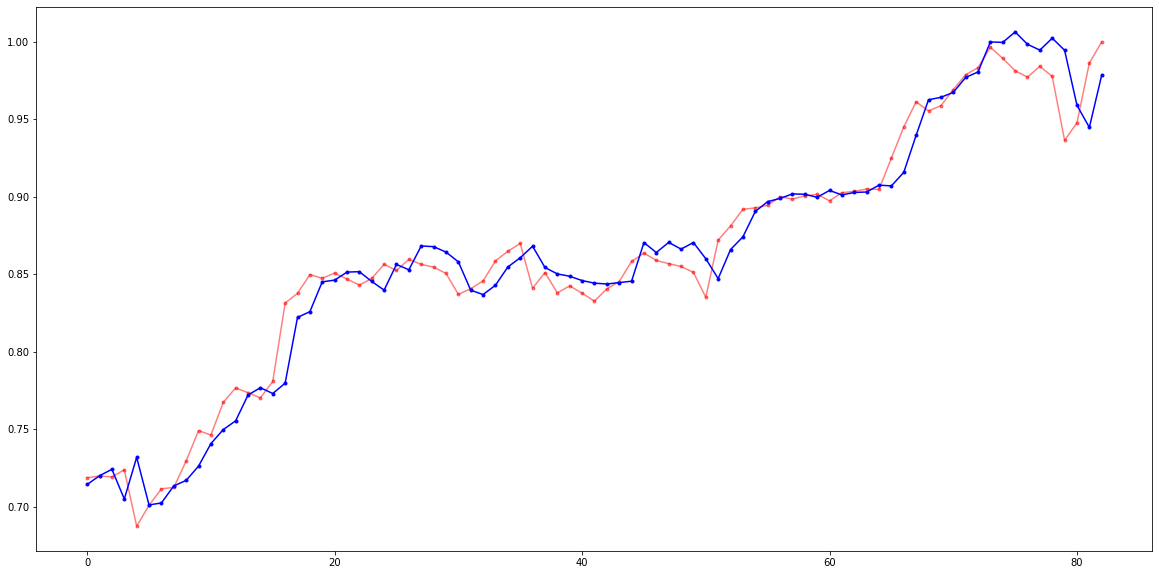

In [ ]:
epochs = 100
batch_size = 32

history = best_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
# history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,

                         validation_split = 0.2,
                        # validation_data=(x_val, y_val), 
                         verbose=1,
                        shuffle=False, callbacks=[earlystop])

loss = history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.savefig("loss_baseline_AAPL.jpg")
plt.show()
# y_pred = model.predict(x_test)
y_pred = best_model.predict(x_test)

print("r2_score:", r2_score(y_pred, y_test))

plt.figure(figsize=(20, 10))
plt.plot(y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.savefig("baseline_AAPL.jpg")
plt.show()


In [ ]:
y_60m= y_pred
y_60m.tofile('/content/drive/MyDrive/551Project/y_60m_AAPL.csv', sep=',')

# New Section

In [ ]:
model = Sequential()
model.add(LSTM(units=467,
            input_shape=(x_train.shape[1], x_train.shape[2]), activation="relu",
            ))
model.add(Dropout(0.25))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# model = tensorflow.keras.models.load_model("/content/drive/MyDrive/551Project/baseline_lookback5.h5")

Epoch 1/200
9/9 [==============================] - 2s 80ms/step - loss: 0.0263 - val_loss: 0.0437
Epoch 2/200
9/9 [==============================] - 0s 53ms/step - loss: 0.0514 - val_loss: 0.0245
Epoch 3/200
9/9 [==============================] - 0s 54ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 4/200
9/9 [==============================] - 0s 50ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 5/200
9/9 [==============================] - 0s 52ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 6/200
9/9 [==============================] - 0s 51ms/step - loss: 0.0019 - val_loss: 9.3190e-04
Epoch 7/200
9/9 [==============================] - 0s 53ms/step - loss: 0.0020 - val_loss: 9.2031e-04
Epoch 8/200
9/9 [==============================] - 0s 55ms/step - loss: 0.0017 - val_loss: 9.3542e-04
Epoch 9/200
9/9 [==============================] - 0s 53ms/step - loss: 0.0024 - val_loss: 9.4285e-04
Epoch 10/200
9/9 [==============================] - 0s 53ms/step - loss: 0.0022 - val_loss: 8.5654e-04

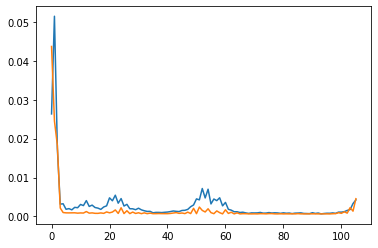

r2_score: -1.1307809270088844


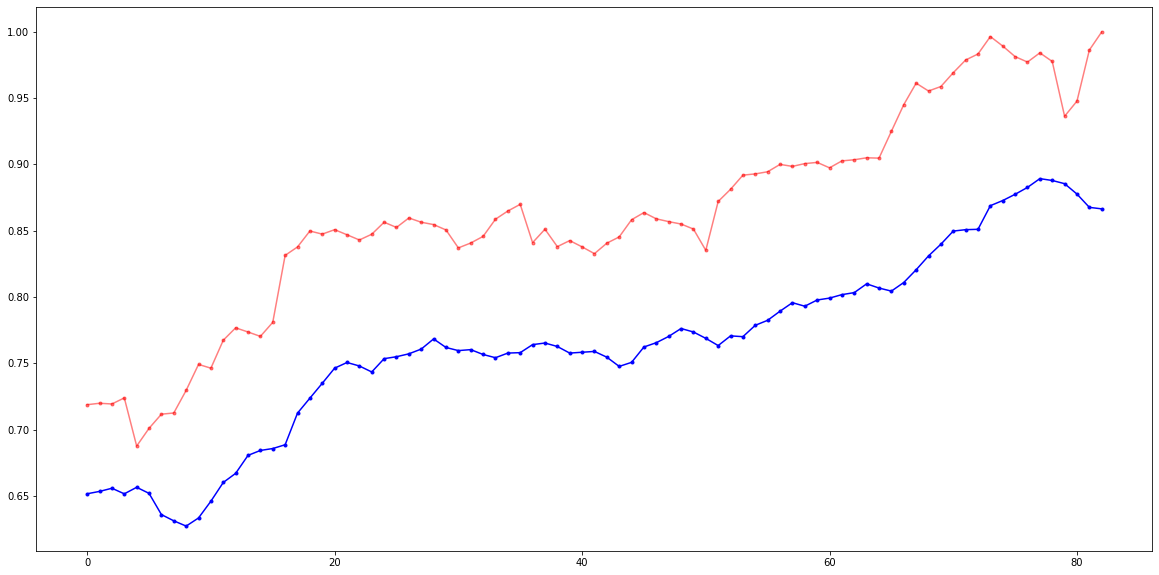

In [ ]:
epochs = 200
batch_size = 32

# history = best_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,

                         validation_split = 0.2,
                        # validation_data=(x_val, y_val), 
                         verbose=1,
                        shuffle=False, callbacks=[earlystop])

loss = history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.savefig("tweet_AAPL.jpg")
plt.show()
y_pred = model.predict(x_test)
# y_pred = best_model.predict(x_test)

print("r2_score:", r2_score(y_pred, y_test))

plt.figure(figsize=(20, 10))
plt.plot(y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot(y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.savefig("tweet_AAPL.jpg")
plt.show()


In [ ]:
loss = model.evaluate(x_test, y_pred)

5/5 [==============================] - 0s 15ms/step - loss: 4.2633e-15


In [ ]:
y_30m= y_pred
y_30m.tofile('/content/drive/MyDrive/551Project/y_30m.csv', sep=',')

In [ ]:
y_test.tofile('/content/drive/MyDrive/551Project/y_real_60m.csv', sep=',')